In [219]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cleanup

In [220]:
#cleanup.clean_up()

In [239]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = []
        self.labels = []

        # 获取数据文件夹中的文件列表和标签
        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if os.path.isdir(label_dir):
                files = os.listdir(label_dir)
                self.file_list.extend(files)
                self.labels.extend([label] * len(files))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, self.labels[idx], file_name)
        data = np.load(file_path)['matrix1']
        label = self.labels[idx]

        if self.transform:
            data = self.transform(data)
        
        return data, label


def normalize_array(arr):
    arr = np.clip(arr, 0, 0.01)  # 将数值限制在0到0.01之间
    arr = (arr - 0) / (0.01 - 0)  # 归一化到0到1之间
    return arr


def numpy_to_pil(sample):
    sample = normalize_array(sample)
    sample = Image.fromarray(sample, mode='F')  # 指定图像模式为单通道
    return sample


data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(numpy_to_pil),  # 添加自定义转换函数
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Lambda(numpy_to_pil),  # 添加自定义转换函数
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
}

data_dir = '.\\preprocess'

image_datasets = {x: CustomDataset(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = ['positive', 'negative']  # 如果您的数据集有类别标签，可以在这里添加类别名

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

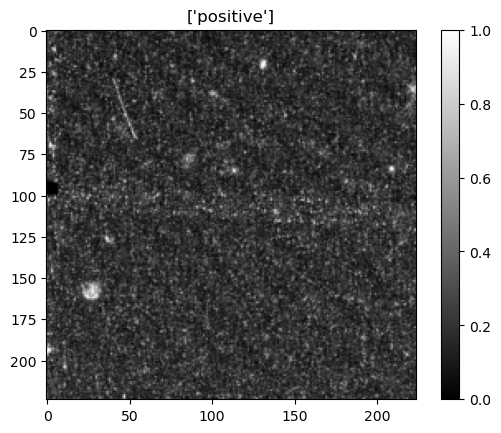

In [240]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.squeeze().numpy()
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap='gray', vmin=0, vmax=1)  # 指定灰度色彩映射
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs.unsqueeze(0))  # 将输入转换为四维张量

imshow(out[0], title=[x for x in classes])